In [1]:
from collections import Counter
import copy
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
from tqdm import tqdm
import utils
import sampling

In [2]:
class FederatedModel:
    def __init__(
        self,
        device,
        num_devices=110,
        num_trusted_devices=None,
        use_trusted=False,
        num_malicious_devices=0,
        network='lenet',
        global_rounds=3,
        local_epochs=5,
        batch_size=64,
        learning_rate=0.001,
        optim='adam',
        dataset='mnist',
        split_type='iid',
        malicious_device_args={},
    ):
        self.network = network
        self.dataset = dataset
        self.num_devices = num_devices
        self.global_rounds = global_rounds
        self.batch_size = batch_size
        self.local_epochs = local_epochs
        self.learning_rate = learning_rate
        self.optim = optim
        self.device = device
        self.num_trusted_devices = num_trusted_devices
        self.use_trusted = use_trusted
        self.num_malicious_devices = num_malicious_devices
        self.malicious_device_args = malicious_device_args

        self.global_network = utils.get_network(network, dataset).to(device)
        self.train_dataset, self.test_dataset = utils.get_dataset(dataset)


        self.train_dataset_idxs = sampling.split_dataset(
            self.train_dataset, num_devices, split_type
        )

        while any(len(x) == 0 for x in self.train_dataset_idxs):
            self.train_dataset_idxs = sampling.split_dataset(
                self.train_dataset, num_devices, split_type
            )

        np.random.shuffle(self.train_dataset_idxs) # Needed?

        self.train_dataset_classes = [Counter([self.train_dataset[idx][1] for idx in idxs]) for idxs in self.train_dataset_idxs]
        print("Len of train_dataset_classes: ",len(self.train_dataset_classes))
        print("train_dataset_classes: ",self.train_dataset_classes[0])
        
        if self.num_trusted_devices is None and self.use_trusted:
            self.num_trusted_devices = 1
            self.trusted_devices = {0}
            self.trusted_devices_classes = self.train_dataset_classes[0]
            
            print("Keys of trusted_devices_classes:",self.trusted_devices_classes.keys())

            while len(self.trusted_devices_classes.keys()) < 10: # TODO: Don't hardcode classes
                x = random.choice(list(set(range(len(self.train_dataset_idxs))) - self.trusted_devices))
                print("Length of trusted device: ",len(self.trusted_devices))
                if len(set(self.train_dataset_classes[x].keys()) - set(self.trusted_devices_classes.keys())) > 0:
                    self.trusted_devices |=  {x}
                    self.trusted_devices_classes += self.train_dataset_classes[x]
                    self.num_trusted_devices += 1
        
        self.train_dataset_idxs = (
            [x for i, x in enumerate(self.train_dataset_idxs) if i in self.trusted_devices] +
            [x for i, x in enumerate(self.train_dataset_idxs) if i not in self.trusted_devices]
        )

        print("==============To find the malicious devices=============")
        print("Trusted devices: ", (self.num_trusted_devices))
        print("Malicious devices: ", self.num_malicious_devices)
        print("Range: ", range(self.num_trusted_devices, self.num_malicious_devices))
        
        self.trusted_devices = list(range(self.num_trusted_devices))
        self.malicious_devices = list(range(self.num_trusted_devices, self.num_malicious_devices))
        
        print("malicious_devices:",self.malicious_devices)

        if num_malicious_devices > 0 and malicious_device_args.get('wrong_dataset') == True:
            self.wrong_train_dataset, _ = utils.get_dataset('cifar10' if dataset == 'mnist' else 'mnist')

    def get_loader(self, dataset):
        return DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

    def get_local_dataset(self, d, is_malicious):
        if is_malicious:
            if self.malicious_device_args.get('flip') is not None:
                n_flip = self.malicious_device_args.get('flip')
                dataset = torch.utils.data.Subset(self.train_dataset, self.train_dataset_idxs[d])
                return utils.FlippedDataset(dataset, 10, n_flip) # TODO: Change 10
            elif self.malicious_device_args.get('wrong_dataset') == True:
                device_dataset_size = int(len(self.train_dataset) / self.num_devices)
                dataset_idxs = list(range(len(self.wrong_train_dataset)))
                random.shuffle(dataset_idxs)
                return torch.utils.data.Subset(
                    self.wrong_train_dataset, dataset_idxs[:device_dataset_size]
                )

        return torch.utils.data.Subset(self.train_dataset, self.train_dataset_idxs[d])

    def train(self, calculate_global_cosine=False, calculate_local_grad_cosine=False):
        stats = []
        for r in range(self.global_rounds):
            global_weights, _, round_stats = self.train_one_round(r, calculate_global_cosine, calculate_local_grad_cosine)

            self.global_network.load_state_dict(global_weights)
            round_stats['test_accuracy'] = utils.check_accuracy(
                self.get_loader(self.test_dataset),
                self.global_network,
                self.device
            )
            stats.append(round_stats)

        return pd.DataFrame(stats)
    
    def train_one_round(self, r, calculate_global_cosine=False, calculate_local_grad_cosine=False):
        malicious_devices = self.malicious_devices

        local_weights = []
        stats = {}
        
        #print("Global_cosine value: ", str(calculate_global_cosine))
        #print("Local_grad_cosine: ",str(calculate_local_grad_cosine))

        for d in tqdm(range(self.num_devices)):
            local_weights.append(self.train_device(d, d in malicious_devices, stats))
            if calculate_global_cosine:
                local_network = utils.get_network(self.network, self.dataset).to(self.device)
                local_network.load_state_dict(local_weights[-1])
                stats[f'{d}_cosine'] = utils.model_cosine(self.global_network, local_network)

        
        if calculate_local_grad_cosine:
            for i in range(self.num_trusted_devices):
                for j in range(self.num_devices):
                    x = utils.get_network(self.network, self.dataset).to(self.device)
                    y = utils.get_network(self.network, self.dataset).to(self.device)
                    x.load_state_dict(local_weights[i])
                    y.load_state_dict(local_weights[j])
                    stats[f"{i}_{j}_cosine"] = utils.model_grad_cosine(
                        self.global_network, x, y
                    )
        
        global_weights = utils.model_average(local_weights)

        return global_weights, local_weights, stats

    def train_device(self, d, is_malicious, stats):
        network = copy.deepcopy(self.global_network).to(self.device)

        optim = self.get_optim(network, is_malicious)
        dataset = self.get_local_dataset(d, is_malicious)
        total_loss = 0

        for _, (data, targets) in enumerate(self.get_loader(dataset)):
            data = data.to(device=self.device)
            targets = targets.to(device=self.device)
            #print("Type target: ", (targets.dtype))
            targets=targets.long()
            #print("Type target: ", (targets.dtype))
            #print("Targets values: ", targets)
            loss = F.cross_entropy(network(data), targets)
            total_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()

        return network.state_dict()

    def get_optim(self, model, is_malicious):
        lr = self.learning_rate
        if is_malicious and self.malicious_device_args.get('lr') is not None:
            lr = self.malicious_device_args['lr']

        if self.optim == "sgd":
            return torch.optim.SGD(model.parameters(), lr=lr)
        elif self.optim == "adam":
            return torch.optim.Adam(model.parameters(), lr=lr)
        else:
            raise NotImplementedError("Invalid Optimizer")

In [3]:
def phase0(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase0',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        local_epochs=local_epochs,
        global_rounds=global_rounds
        )

    stats = model.train().astype('float')
    stats.to_excel(f'{f}.xlsx')

    print(f)
    print(stats)


In [4]:
def phase1(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase1',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        local_epochs=local_epochs,
        global_rounds=global_rounds
        )

    stats = model.train(calculate_global_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    plt.clf()
    ss = stats[[f'{i}_cosine' for i in range(110)]].astype(float).to_numpy()
    ax = sns.heatmap(ss)
    ax.figure.savefig(f'{f}_heatmap.png')

    print(f)
    print(stats)

In [5]:
def phase2(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase2',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        num_trusted_devices=1,
        use_trusted=True,
        local_epochs=local_epochs,
        global_rounds=global_rounds
    )

    stats = model.train(calculate_local_grad_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    plt.clf()
    ss = stats[[f'0_{j}_cosine' for j in range(1, 110)]].astype(float).to_numpy()
    ax = sns.heatmap(ss)
    ax.figure.savefig(f'{f}_heatmap.png')

    print(f)
    print(stats)

In [6]:
def phase3(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase3',
    local_epochs=5, 
    global_rounds=3):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        num_trusted_devices=None, # Automatically assign trusted devices
        use_trusted=True,
        local_epochs=local_epochs,
        global_rounds=global_rounds
    )

    stats = model.train(calculate_local_grad_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    for i in range(model.num_trusted_devices):
        plt.clf()
        ss = stats[[f'{i}_{j}_cosine' for j in range(model.num_devices)]].astype(float).to_numpy()
        ax = sns.heatmap(ss)
        ax.figure.savefig(f'{f}_{i}_heatmap.png')

    print(f)
    print(stats)


In [7]:
def experiment(device, niids, malicious_types, phase, global_rounds=10, local_epochs=5):
    print("Phase number:", str(phase))
    #phase(device=device, split_type='iid')

#     for niid in niids:
#         print("niid is:", niid)
#         phase(
#             device=device,
#             split_type=f'niid-{niid}',
#             local_epochs=local_epochs,
#             global_rounds=global_rounds)

    for mt in malicious_types:
        print("mt is:", mt)
#         phase(
#             device=device, 
#             split_type='iid', 
#             malicious_type=mt,
#             num_malicious_devices=30, 
#             local_epochs = local_epochs,
#             global_rounds=global_rounds)

        for niid in niids:
            phase(
                device=device, 
                split_type=f'niid-{niid}', 
                malicious_type=mt,
                num_malicious_devices=30, 
                local_epochs=local_epochs,
                global_rounds=global_rounds)

Phase number: <function phase3 at 0x000001E07C0C9F70>
mt is: {'flip': 5}


D:\software\anaconda3\envs\anupam\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Len of train_dataset_classes:  110
train_dataset_classes:  Counter({1: 281, 7: 261, 3: 256, 2: 248, 9: 248, 0: 247, 8: 244, 4: 243})
Keys of trusted_devices_classes: dict_keys([0, 1, 2, 3, 4, 7, 8, 9])
Length of trusted device:  1
==============To find the malicious devices=============
Trusted devices:  2
Malicious devices:  30
Range:  range(2, 30)
malicious_devices: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


  0%|                                                                                          | 0/110 [00:00<?, ?it/s]D:\software\anaconda3\envs\anupam\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:44<00:00,  2.45it/s]


outputs/phase3_niid-20_flip_5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.010818    0.280449    0.102603    0.015598   -0.074681   
1         1.0    0.211377    0.404148    0.049080   -0.014513    0.118952   
2         1.0    0.361481    0.346618    0.229867    0.216465    0.088366   
3         1.0    0.403593    0.257658    0.031136    0.142674    0.117418   
4         1.0    0.373912    0.332363    0.107804    0.258138   -0.034485   
5         1.0    0.289473    0.365374   -0.027716   -0.062608   -0.092634   
6         1.0    0.217915    0.390819   -0.106323   -0.040157   -0.055076   
7         1.0    0.207143    0.171010    0.028455   -0.081295    0.026798   
8         1.0    0.116148    0.093165   -0.053763   -0.039318   -0.002183   
9         1.0    0.095320    0.226538    0.033027   -0.055107   -0.014027   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  1_101_cosine  \
0    0.130020    0.099745    0.005275    0.0245

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:51<00:00,  2.15it/s]


outputs/phase3_niid-40_flip_5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.070732    0.036741    0.319458    0.185508   -0.021885   
1         1.0    0.209579    0.060593   -0.069313    0.271940    0.386539   
2         1.0    0.197496    0.114007    0.314284    0.439720    0.057477   
3         1.0    0.247879    0.113991   -0.115856    0.092893   -0.039445   
4         1.0    0.236684    0.096671   -0.087413    0.105972   -0.115963   
5         1.0    0.240665    0.052549   -0.021470   -0.044709   -0.123835   
6         1.0    0.054861    0.105105    0.004531   -0.007954    0.395108   
7         1.0    0.094282    0.143926    0.053159    0.423011    0.099290   
8         1.0    0.067789    0.089524    0.078071    0.048790    0.458542   
9         1.0    0.077794    0.009861    0.003524   -0.077440    0.155605   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  2_101_cosine  \
0    0.229437    0.202671    0.084434   -0.0247

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:22<00:00,  1.33it/s]


outputs/phase3_niid-60_flip_5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0   -0.187816    0.063895    0.543172   -0.036504   -0.060981   
1         1.0   -0.135051    0.097988    0.539054    0.083740    0.066667   
2         1.0   -0.126528    0.072928    0.601161   -0.053600    0.236170   
3         1.0   -0.170252    0.029054    0.628898   -0.168139    0.143177   
4         1.0   -0.175627   -0.026804    0.674011   -0.011042    0.072410   
5         1.0   -0.240104   -0.075784    0.681710   -0.069283    0.148040   
6         1.0   -0.236913   -0.078908    0.692448   -0.028762    0.063598   
7         1.0   -0.208203   -0.127639    0.726895    0.255201    0.395286   
8         1.0   -0.261574   -0.159593    0.660398   -0.049670    0.171240   
9         1.0   -0.311357   -0.184125    0.693825    0.169008    0.341142   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  3_101_cosine  \
0   -0.152711   -0.140809   -0.061828    0.4204

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:20<00:00,  1.36it/s]


outputs/phase3_niid-80_flip_5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0   -0.091529    0.355173   -0.068021   -0.052497   -0.174071   
1         1.0   -0.068393    0.389236   -0.086502   -0.205132   -0.063624   
2         1.0   -0.158403    0.317727   -0.162404   -0.175547    0.018259   
3         1.0   -0.064722    0.246962   -0.230414   -0.090364    0.008429   
4         1.0   -0.028347    0.209557   -0.304956   -0.141672   -0.005619   
5         1.0   -0.087945    0.198665   -0.334106   -0.196755   -0.013405   
6         1.0   -0.083875    0.332306   -0.367533   -0.188490   -0.033568   
7         1.0   -0.097318    0.267518   -0.286057   -0.213973    0.010724   
8         1.0   -0.158680    0.281180   -0.391831   -0.223409   -0.094401   
9         1.0   -0.111705    0.289137   -0.202242   -0.239580   -0.099022   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  5_101_cosine  \
0    0.840240    0.872516    0.210022   -0.0923

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:17<00:00,  1.41it/s]


outputs/phase3_niid-20_wrong_dataset_True_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.351937    0.349088    0.033455    0.037759    0.020640   
1         1.0    0.529408    0.433265   -0.010627   -0.066695   -0.078633   
2         1.0    0.606229    0.460411   -0.059097   -0.071461   -0.086799   
3         1.0    0.651711    0.508123   -0.143433   -0.226583   -0.117578   
4         1.0    0.611141    0.458147   -0.197973   -0.182229   -0.209122   
5         1.0    0.590036    0.425558   -0.256652   -0.269050   -0.247117   
6         1.0    0.552210    0.390121   -0.316977   -0.315541   -0.273226   
7         1.0    0.465520    0.328343   -0.242917   -0.227424   -0.235157   
8         1.0    0.444982    0.308755   -0.291291   -0.244466   -0.265360   
9         1.0    0.411372    0.245644   -0.286753   -0.258823   -0.272230   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  2_101_cosine  \
0   -0.015213   -0.008646    0.1025

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:03<00:00,  1.73it/s]


outputs/phase3_niid-40_wrong_dataset_True_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.443519    0.369810   -0.051422   -0.034355    0.090003   
1         1.0    0.483851    0.522493    0.121775   -0.027175    0.095531   
2         1.0    0.461665    0.522695    0.077699   -0.023665   -0.115910   
3         1.0    0.356471    0.495773    0.075701   -0.149886   -0.149918   
4         1.0    0.192869    0.439052    0.051721   -0.103678   -0.209449   
5         1.0    0.260411    0.419995    0.021522   -0.182061   -0.165843   
6         1.0    0.278939    0.424831    0.025163   -0.287010   -0.317601   
7         1.0    0.233543    0.477896   -0.020625   -0.223552   -0.280598   
8         1.0    0.159368    0.276252   -0.064485   -0.266133   -0.262732   
9         1.0    0.238386    0.314421   -0.061638   -0.310744   -0.308221   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  3_101_cosine  \
0    0.044838    0.104527    0.0056

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:14<00:00,  1.47it/s]


outputs/phase3_niid-60_wrong_dataset_True_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.008330    0.441698    0.049408    0.030942    0.012812   
1         1.0   -0.045361    0.542347    0.006989   -0.058548   -0.043052   
2         1.0   -0.044405    0.563045   -0.102288    0.051150    0.010141   
3         1.0    0.010923    0.530650   -0.085620    0.022105    0.158346   
4         1.0    0.018181    0.583505   -0.058660    0.014768    0.040229   
5         1.0    0.033861    0.593471   -0.052273    0.045468    0.094176   
6         1.0    0.011294    0.575460   -0.091476   -0.053325   -0.011015   
7         1.0    0.024370    0.593740   -0.070262   -0.014371   -0.017654   
8         1.0    0.031260    0.567479   -0.144083   -0.066745   -0.080458   
9         1.0    0.003830    0.559072   -0.153207   -0.048346   -0.075327   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  3_101_cosine  \
0    0.097231   -0.007000   -0.0747

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:15<00:00,  1.46it/s]


outputs/phase3_niid-80_wrong_dataset_True_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.126314    0.050783   -0.043521    0.062595   -0.079675   
1         1.0    0.176471    0.089354   -0.051970    0.018580   -0.064968   
2         1.0    0.133585    0.006117   -0.026245    0.036255   -0.013687   
3         1.0    0.085199   -0.102136   -0.081227    0.012726    0.000327   
4         1.0    0.090390   -0.139545   -0.085715   -0.023776   -0.014750   
5         1.0   -0.013804   -0.070373   -0.117106    0.022387   -0.017542   
6         1.0    0.006547   -0.004279   -0.102855    0.023723    0.011570   
7         1.0   -0.013880   -0.029543   -0.147317    0.000465   -0.001947   
8         1.0    0.036420   -0.029236   -0.079206   -0.023084   -0.057562   
9         1.0    0.003926   -0.052978   -0.095948   -0.014309   -0.088771   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  5_101_cosine  \
0   -0.035653    0.122435    0.0109

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:07<00:00,  1.62it/s]


outputs/phase3_niid-20_lr_0.5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.101035    0.279497    0.379416    0.468475    0.140378   
1         1.0   -0.093911    0.187925    0.086872    0.943181   -0.010815   
2         1.0   -0.172094    0.301947    0.246609    0.895500   -0.180315   
3         1.0   -0.384993    0.116360    0.230333    0.651753   -0.511545   
4         1.0    0.121452    0.240888    0.275431    0.792925   -0.352384   
5         1.0    0.033929    0.218212    0.241839    0.949312   -0.355207   
6         1.0   -0.109040    0.223513    0.186755    0.731274   -0.388519   
7         1.0   -0.097176    0.383504    0.262561    0.771795   -0.413659   
8         1.0    0.087714    0.422073    0.575656    0.680019   -0.360139   
9         1.0   -0.180027    0.220118    0.117120    0.788218    0.276595   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  1_101_cosine  \
0    0.377324    0.436397    0.181887    0.4385

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:36<00:00,  1.14it/s]


outputs/phase3_niid-40_lr_0.5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0   -0.032364    0.439487    0.390951   -0.085572   -0.014475   
1         1.0   -0.762116    0.871663    0.923974   -0.270280    0.078821   
2         1.0   -0.756971    0.909087    0.829720    0.067665   -0.252931   
3         1.0   -0.624497    0.893653    0.951675    0.156449   -0.218129   
4         1.0   -0.684999    0.906091    0.906092    0.190734   -0.017967   
5         1.0   -0.706730    0.941491    0.818125    0.216758    0.038755   
6         1.0   -0.823518    0.806181    0.890222   -0.050850    0.012502   
7         1.0   -0.746039    0.831475    0.867628   -0.084098   -0.017769   
8         1.0   -0.538112    0.953368    0.823630    0.110252   -0.179909   
9         1.0   -0.513821    0.835109    0.797372    0.064664   -0.202605   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  1_101_cosine  \
0    0.418235    0.176556    0.397356    0.4608

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:08<00:00,  1.61it/s]


outputs/phase3_niid-60_lr_0.5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.238571    0.344792   -0.043064   -0.065604   -0.117652   
1         1.0    0.215669    0.196325   -0.588766   -0.233864   -0.164224   
2         1.0    0.209933    0.197444   -0.581491   -0.229006   -0.237584   
3         1.0    0.269379    0.159729   -0.536775   -0.282328   -0.281388   
4         1.0    0.245446    0.163026   -0.569290   -0.294736   -0.279759   
5         1.0    0.331768    0.124793   -0.485049   -0.242190   -0.275924   
6         1.0    0.355920    0.121568   -0.469209   -0.308455   -0.326214   
7         1.0    0.371750    0.090727   -0.441924   -0.322408   -0.163692   
8         1.0    0.355454    0.137901   -0.468650   -0.246561   -0.274182   
9         1.0    0.315580    0.106052   -0.514357   -0.329202   -0.237630   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  3_101_cosine  \
0    0.017533   -0.081292   -0.080283   -0.0805

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:58<00:00,  1.90it/s]


outputs/phase3_niid-80_lr_0.5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0   -0.095298   -0.058498   -0.098202    0.341143   -0.110729   
1         1.0    0.013764    0.045430    0.217595    0.658421    0.022633   
2         1.0    0.092629    0.091609    0.234597    0.631932    0.095118   
3         1.0    0.102987    0.102982    0.179374    0.630450    0.103866   
4         1.0    0.105404    0.104854    0.126810    0.632030    0.105355   
5         1.0    0.105616    0.105311    0.114447    0.629674    0.106515   
6         1.0    0.102963    0.104060    0.110754    0.629873    0.103802   
7         1.0    0.114398    0.113473    0.116443    0.627392    0.114496   
8         1.0    0.126158    0.124940    0.127138    0.625753    0.125503   
9         1.0    0.125428    0.125327    0.128847    0.623159    0.124730   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  5_101_cosine  \
0    0.750424    0.289794    0.203053    0.6913

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:01<00:00,  1.78it/s]


outputs/phase3_niid-20_lr_1e-05_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.508254    0.024831    0.042489    0.190729    0.046628   
1         1.0    0.603307    0.234866    0.304320    0.319891    0.278677   
2         1.0    0.672947    0.328665    0.357428    0.303412    0.342427   
3         1.0    0.643046    0.347764    0.403653    0.274038    0.396215   
4         1.0    0.625667    0.358917    0.391483    0.298400    0.402567   
5         1.0    0.586821    0.300665    0.326735    0.233558    0.291067   
6         1.0    0.554094    0.253314    0.239060    0.169127    0.219558   
7         1.0    0.479255    0.222011    0.138215    0.145612    0.114388   
8         1.0    0.466432    0.180489    0.067575    0.084032    0.015780   
9         1.0    0.414401    0.181595    0.034537    0.063987    0.022327   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  1_101_cosine  \
0    0.198028    0.036713    0.153523    0.06

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:54<00:00,  2.01it/s]


outputs/phase3_niid-40_lr_1e-05_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.214622   -0.074073   -0.075025    0.244395   -0.245470   
1         1.0    0.167893    0.049541   -0.255455    0.171206   -0.301237   
2         1.0    0.114135    0.101589   -0.359022    0.021051   -0.218552   
3         1.0   -0.015087    0.075323   -0.285292   -0.098328   -0.132714   
4         1.0   -0.038275    0.037580   -0.221533   -0.067319   -0.094360   
5         1.0   -0.166443   -0.006302   -0.253619   -0.245105   -0.088699   
6         1.0   -0.219720   -0.005761   -0.242343   -0.287710   -0.037268   
7         1.0   -0.276372   -0.086128   -0.267384   -0.308019   -0.093655   
8         1.0   -0.209507   -0.072312   -0.137278   -0.274245   -0.090749   
9         1.0   -0.135045   -0.043885   -0.199235   -0.206588    0.015811   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  2_101_cosine  \
0    0.594436    0.088994    0.093210    0.28

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:06<00:00,  1.65it/s]


outputs/phase3_niid-60_lr_1e-05_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.441381    0.376638   -0.054278   -0.125224   -0.212345   
1         1.0    0.541449    0.368104    0.009457   -0.079658   -0.233894   
2         1.0    0.552565    0.383977   -0.059225   -0.158214   -0.141194   
3         1.0    0.575597    0.425708    0.010535   -0.135088   -0.059883   
4         1.0    0.593564    0.389236   -0.022903   -0.118014   -0.021995   
5         1.0    0.587854    0.413591   -0.106885   -0.133956    0.037694   
6         1.0    0.603499    0.409088   -0.089155   -0.122597    0.026797   
7         1.0    0.604516    0.403013   -0.070373   -0.123459    0.018156   
8         1.0    0.606009    0.397960   -0.085918   -0.182145   -0.030498   
9         1.0    0.581049    0.380562   -0.085094   -0.192276   -0.011956   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  4_101_cosine  \
0    0.233225   -0.073200   -0.248698   -0.07

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:56<00:00,  1.95it/s]


outputs/phase3_niid-80_lr_1e-05_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.104877    0.480102    0.066692   -0.049043    0.440612   
1         1.0    0.069392    0.521610    0.074529    0.011084    0.371156   
2         1.0    0.057120    0.426933   -0.047835   -0.128340    0.344158   
3         1.0    0.099456    0.443224   -0.162820   -0.230735    0.373403   
4         1.0    0.128675    0.451314   -0.208321   -0.223693    0.380291   
5         1.0    0.129681    0.481385   -0.192305   -0.231124    0.336952   
6         1.0    0.118164    0.372343   -0.165319   -0.191178    0.308087   
7         1.0    0.088250    0.382672   -0.155200   -0.227483    0.305188   
8         1.0    0.067011    0.443238   -0.185972   -0.225654    0.296367   
9         1.0    0.090696    0.405767   -0.157653   -0.188375    0.263126   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  5_101_cosine  \
0   -0.101403   -0.012017   -0.095794   -0.09

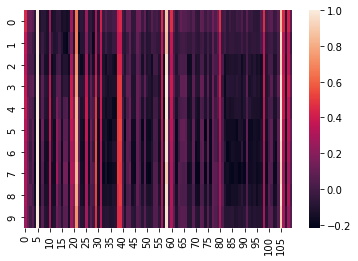

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
niids = [20, 40, 60, 80]
malicious_types = [{'flip': 5}, {'wrong_dataset': True}, {'lr':0.5}, {'lr':0.00001}]
experiment(device, niids, malicious_types, phase3)